# Imports

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
get_ipython().run_line_magic('matplotlib', 'inline')
import subprocess
import importlib
import xgboost as xgb
import lightgbm as lgb

# Custom Functions

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

# Add **kwargs as keyword when defining function
# Include **kwargs in the sns.regplot() within the function

def plot_numeric_vs_target(df, x, y='SalePrice', figsize=(6,4), **kwargs): # kwargs for sns.regplot
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','linewidths':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax

  # Add **kwargs as keyword when defining function
# Include **kwargs in the sns.regplot() within the function

# Final version of function
def plot_categorical_vs_target(df, x, y='SalePrice',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax



In [4]:
! pip install statsmodels

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic


def plot_numeric_vs_categorical(df, target_col, numeric_col, norm=False):
    """
    Plots a numeric variable against a categorical target.
    If norm=True, shows normalized (percentage) mean values.
    """
    plt.figure(figsize=(8, 5))
    grouped = df.groupby(target_col)[numeric_col].mean().sort_values()

    if norm:
        grouped = grouped / grouped.sum() * 100
        sns.barplot(x=grouped.index, y=grouped.values)
        plt.ylabel(f"Mean {numeric_col} (% of total mean)")
    else:
        sns.barplot(x=grouped.index, y=grouped.values)
        plt.ylabel(f"Mean {numeric_col}")

    plt.xlabel(target_col)
    plt.title(f"{numeric_col} vs {target_col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Optional statistical test: ANOVA to check if groups differ significantly
    groups = [vals[numeric_col].dropna().values for _, vals in df.groupby(target_col)]
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("→ Significant difference detected between groups.")
    else:
        print("→ No statistically significant difference between groups.")


def plot_categorical_vs_categorical(df, cat_col1, cat_col2, norm=False):
    """
    Plots the relationship between two categorical variables.
    If norm=True, shows percentages instead of raw counts.
    """
    crosstab = pd.crosstab(df[cat_col1], df[cat_col2])

    if norm:
        crosstab = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

    plt.figure(figsize=(8, 5))
    sns.heatmap(
        crosstab,
        annot=True,
        fmt=".1f" if norm else "d",
        cmap="Blues"
    )
    plt.title(f"{cat_col1} vs {cat_col2}")
    plt.ylabel(cat_col1)
    plt.xlabel(cat_col2)
    plt.tight_layout()
    plt.show()

    # Chi-square test for independence
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(df[cat_col1], df[cat_col2]))
    print(f"Chi-square statistic: {chi2:.3f}, p-value: {p:.4f}")
    if p < 0.05:
        print("→ Significant association between the two variables (less than 0.05).")
    else:
        print("→ No statistically significant association found.")


# Read and Understand the data

In [6]:
client_train = pd.read_csv(f"D:\zindi -Fraud detection data\client_train.csv", low_memory=False)
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [7]:
invoice_train = pd.read_csv(f"D:\zindi -Fraud detection data\invoice_train.csv", low_memory=False)
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


## Check Columns Data types

In [8]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


* Invoice_date should be as DateTime data type

In [9]:
# convert invoice_date to datetime
invoice_train['invoice_date'] = pd.to_datetime(invoice_train['invoice_date'])
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype         
---  ------                -----         
 0   client_id             object        
 1   invoice_date          datetime64[ns]
 2   tarif_type            int64         
 3   counter_number        int64         
 4   counter_statue        object        
 5   counter_code          int64         
 6   reading_remarque      int64         
 7   counter_coefficient   int64         
 8   consommation_level_1  int64         
 9   consommation_level_2  int64         
 10  consommation_level_3  int64         
 11  consommation_level_4  int64         
 12  old_index             int64         
 13  new_index             int64         
 14  months_number         int64         
 15  counter_type          object        
dtypes: datetime64[ns](1), int64(12), object(3)
memory usage: 546.5+ MB


In [10]:
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


* creation_date should be as DateTime data type


In [11]:
# convert creation_date to datetime
client_train['creation_date'] = pd.to_datetime(client_train['creation_date'])
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   disrict        135493 non-null  int64         
 1   client_id      135493 non-null  object        
 2   client_catg    135493 non-null  int64         
 3   region         135493 non-null  int64         
 4   creation_date  135493 non-null  datetime64[ns]
 5   target         135493 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.2+ MB


## Check for null values


In [12]:
invoice_train.isna().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

* No null values in the invoice data set

In [13]:
client_train.isna().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

* No null values in the client data set

## Check for duplicates

In [14]:
invoice_train.duplicated().sum()

np.int64(11)

* There are 11 duplicated rows in the invoice data set

In [15]:
# drop duplicates
invoice_train = invoice_train.drop_duplicates()
invoice_train.duplicated().sum()

np.int64(0)

In [16]:
client_train.duplicated().sum()

np.int64(0)

In [17]:
# client_test = pd.read_csv(f"D:\zindi -Fraud detection data\client_test.csv", low_memory=False)
# client_test.head()

In [18]:
# invoice_test = pd.read_csv(f"D:\zindi -Fraud detection data\invoice_test.csv", low_memory=False)
# invoice_test.head() 

## Check for inconcestency

In [19]:
invoice_train['counter_statue'].value_counts()  

counter_statue
0         4379008
1           74036
5           20628
4            2729
3             258
2              32
46             14
A              13
618            12
769             6
269375          1
420             1
Name: count, dtype: int64

* 'A' is the only string value , and it is more likely to be a typo
* The majority of the rows have counter_statue value within this range [0-5] so we will drop the rows that have the other counter_status values

In [20]:
invoice_train=invoice_train[invoice_train['counter_statue'].isin(['0','1','2','3','4','5'])]
invoice_train['counter_statue'].value_counts()

counter_statue
0    4379008
1      74036
5      20628
4       2729
3        258
2         32
Name: count, dtype: int64

* The data type is now fixed to int

In [21]:
invoice_train['counter_type'].value_counts()

counter_type
ELEC    3079352
GAZ     1397339
Name: count, dtype: int64

* No inconsistency

## Check no of unique values 

In [22]:
for col in invoice_train.columns:
    print(f"{col}: {invoice_train[col].nunique()} unique values")

client_id: 135491 unique values
invoice_date: 8275 unique values
tarif_type: 17 unique values
counter_number: 201892 unique values
counter_statue: 6 unique values
counter_code: 40 unique values
reading_remarque: 4 unique values
counter_coefficient: 13 unique values
consommation_level_1: 8295 unique values
consommation_level_2: 12576 unique values
consommation_level_3: 2253 unique values
consommation_level_4: 12075 unique values
old_index: 155648 unique values
new_index: 157980 unique values
months_number: 1351 unique values
counter_type: 2 unique values


* Client date have a unique value for each row -> set as index
* counter number have larg number if unique values -> drop
* old index and new index descripes the last and the new reading of the utility meter and we may create a ne columns whith the difference between them 
* For consuption level 1-4 we may get their mean for each client 

In [23]:
# invoice_train.drop(~invoice_train[invoice_train['counter_statue'].isin(['0','1','2','3','4','5'])].index)['counter_statue'].value_counts()

# EDA

In [24]:
df=pd.merge(invoice_train, client_train, on='client_id', how='left')
df.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,...,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,...,0,14302,14384,4,ELEC,60,11,101,1994-12-31,0.0
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,...,0,12294,13678,4,ELEC,60,11,101,1994-12-31,0.0
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,...,0,14624,14747,4,ELEC,60,11,101,1994-12-31,0.0
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,...,0,14747,14849,4,ELEC,60,11,101,1994-12-31,0.0
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,...,0,15066,15638,12,ELEC,60,11,101,1994-12-31,0.0


## Client data set

### Disrict

In [25]:
client_train['disrict'].value_counts()

disrict
62    40353
69    34231
60    31922
63    28987
Name: count, dtype: int64

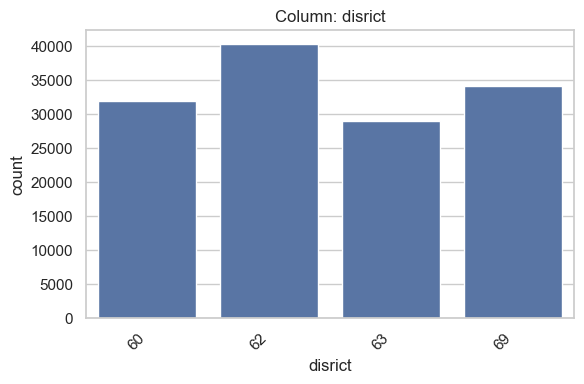

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '62' occurs 40353 times (29.78%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: disrict'}, xlabel='disrict', ylabel='count'>)

In [26]:
explore_categorical(client_train,'disrict')

In [27]:
df['target'].value_counts()

target
0.0    4123582
1.0     353109
Name: count, dtype: int64

Would we know this BEFORE the target is determined? **Yes**.

Is there a business case/understanding reason to exclude based on our business case? Possibly, it may not be possible for a homeowner to modify the utilities available? **No**

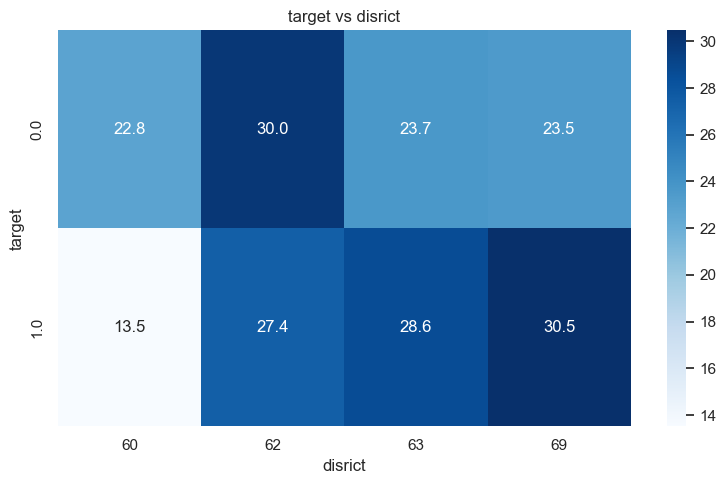

Chi-square statistic: 23347.291, p-value: 0.0000
→ Significant association between the two variables (less than 0.05).


In [28]:
plot_categorical_vs_categorical(df, 'target', 'disrict',norm=True)


- Based on my business understanding,I expect this feature to be a predictor of the target
- Does this feature appear to be a predictor of the target?
    - Yes , it is more likely to be a predictor because Some districts (like 62, 63, 69) have noticeably different proportions for target = 0 vs target = 1

### client_catg

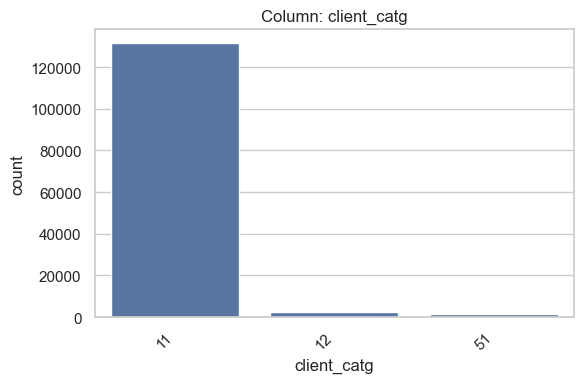

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: '11' occurs 131494 times (97.05%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: client_catg'}, xlabel='client_catg', ylabel='count'>)

In [29]:
explore_categorical(client_train,'client_catg')

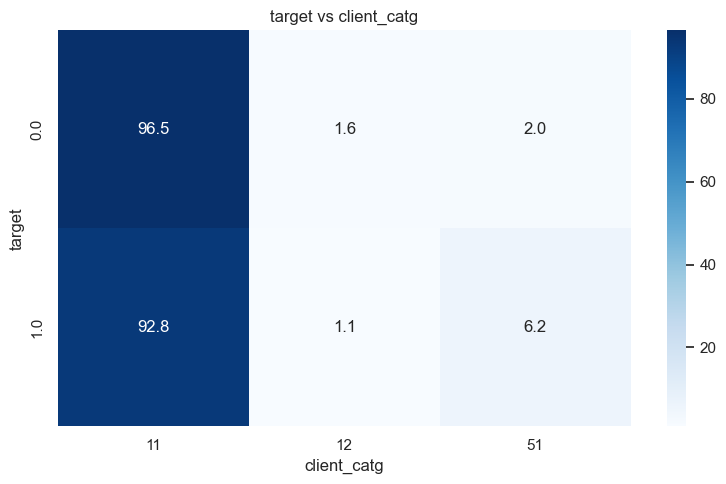

Chi-square statistic: 25377.097, p-value: 0.0000
→ Significant association between the two variables (less than 0.05).


In [30]:
plot_categorical_vs_categorical(df, 'target', 'client_catg',norm=True)

- Based on my business understanding,I expect this feature to be a predictor of the target
- Does this feature appear to be a predictor of the target?
    - Yes , it is more likely to be a predictor because Some districts (like 62, 63, 69) have noticeably different proportions for target = 0 vs target = 1

### region

In [32]:
client_train['region'].value_counts()

region
101    33770
104    12865
311    12406
107     9998
301     9544
103     8964
306     6044
303     5982
310     4851
312     4379
302     4311
304     3828
309     3669
307     3376
305     2716
313     2076
371     2065
105     1645
308      841
106      706
372      644
379      583
399      175
206       53
199        2
Name: count, dtype: int64

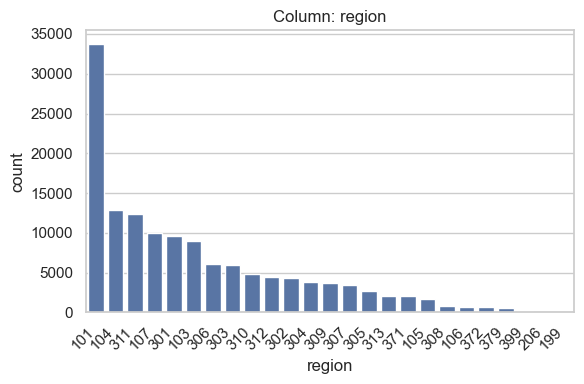

- NaN's Found: 0 (0.0%)
- Unique Values: 25
- Most common value: '101' occurs 33770 times (24.92%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: region'}, xlabel='region', ylabel='count'>)

In [33]:
explore_categorical(client_train,'region',order=client_train['region'].value_counts().index)

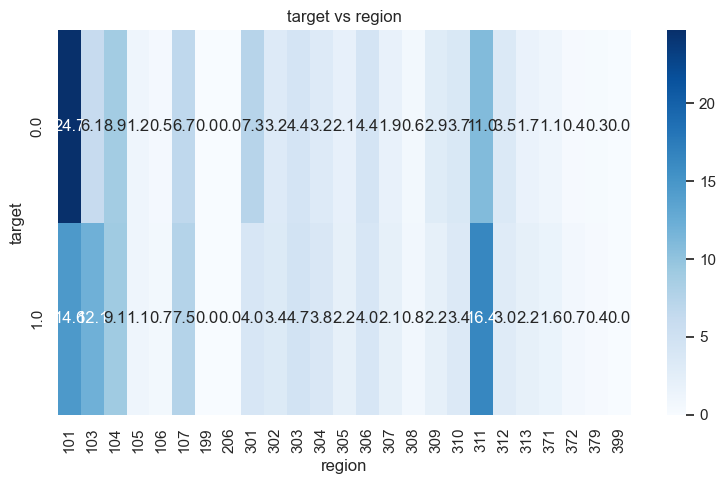

Chi-square statistic: 49528.672, p-value: 0.0000
→ Significant association between the two variables (less than 0.05).


In [70]:
plot_categorical_vs_categorical(df, 'target', 'region',norm=True)

## Invoice data set

### tarif_type

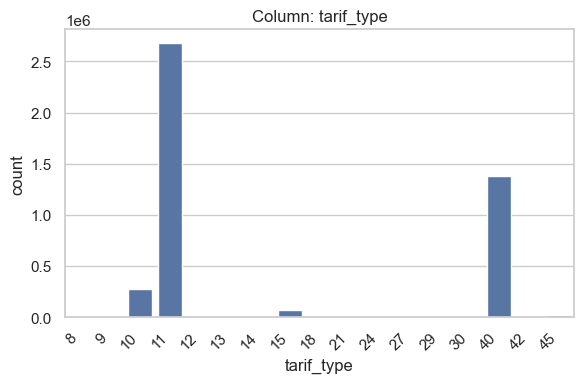

- NaN's Found: 0 (0.0%)
- Unique Values: 17
- Most common value: '11' occurs 2679826 times (59.86%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: tarif_type'}, xlabel='tarif_type', ylabel='count'>)

In [72]:
explore_categorical(invoice_train,'tarif_type')

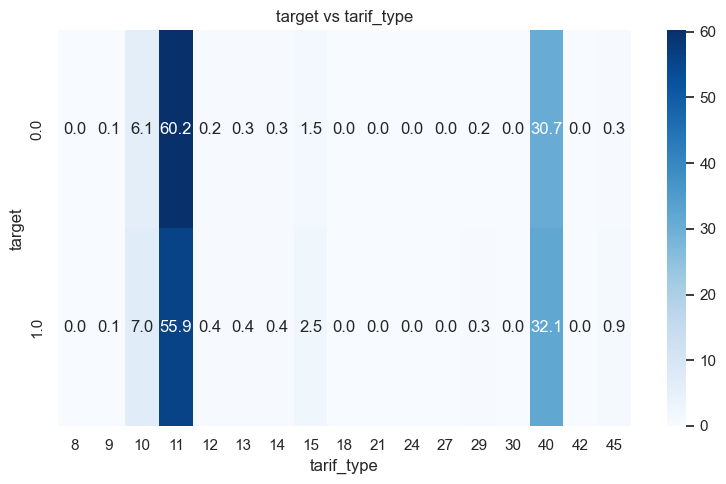

Chi-square statistic: 7284.183, p-value: 0.0000
→ Significant association between the two variables (less than 0.05).


In [81]:
plot_categorical_vs_categorical(df, 'target', 'tarif_type', norm=True)

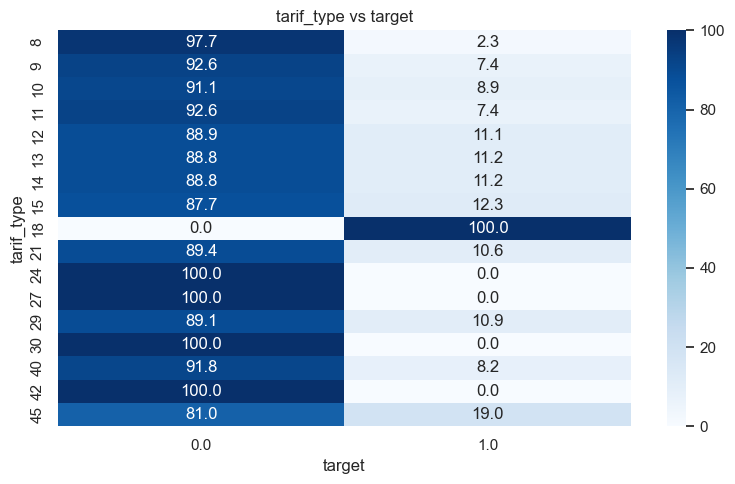

Chi-square statistic: 7284.183, p-value: 0.0000
→ Significant association between the two variables (less than 0.05).


In [82]:
plot_categorical_vs_categorical(df,'tarif_type', 'target',  norm=True)

In [83]:
df['tarif_type'].value_counts()

tarif_type
11    2679831
40    1379751
10     276210
15      72409
45      17552
13      11656
14      11611
12      11345
29      10090
9        6039
21        104
8          43
30         35
24          9
18          4
42          1
27          1
Name: count, dtype: int64

- There is a huge impalance in this feature , we can reduce it by combining the minor tarif_type classes (21,8,30,24,18,42,27) into "other" class

### counter_statue

In [42]:
invoice_train['counter_statue'].value_counts()

counter_statue
0    4379007
1      74036
5      20628
4       2729
3        258
2         32
Name: count, dtype: int64

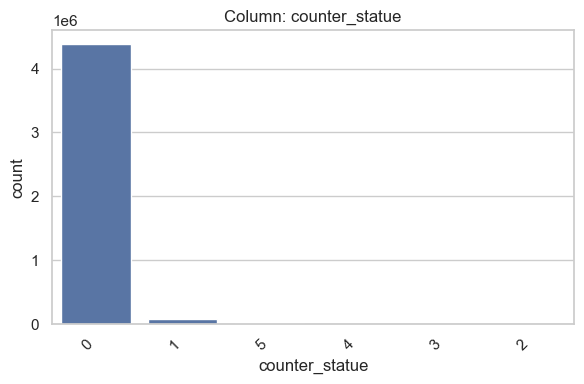

- NaN's Found: 0 (0.0%)
- Unique Values: 6
- Most common value: '0' occurs 4379007 times (97.82%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: counter_statue'}, xlabel='counter_statue', ylabel='count'>)

In [43]:
explore_categorical(invoice_train,'counter_statue')

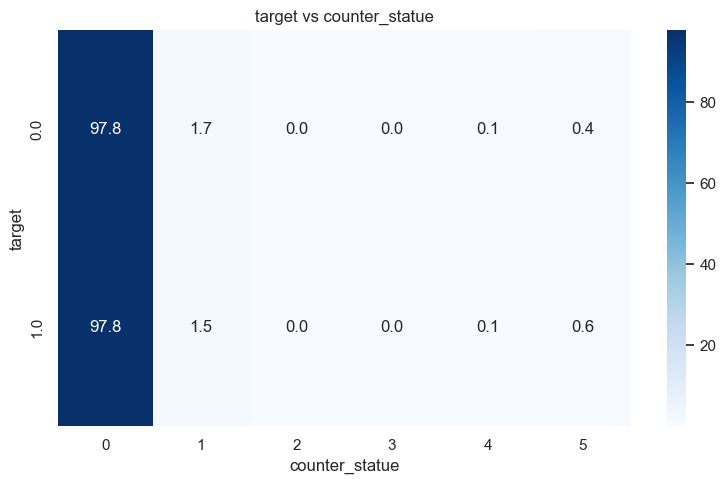

Chi-square statistic: 224.505, p-value: 0.0000
→ Significant association between the two variables (less than 0.05).


In [84]:
plot_categorical_vs_categorical(df, 'target', 'counter_statue', norm=True)

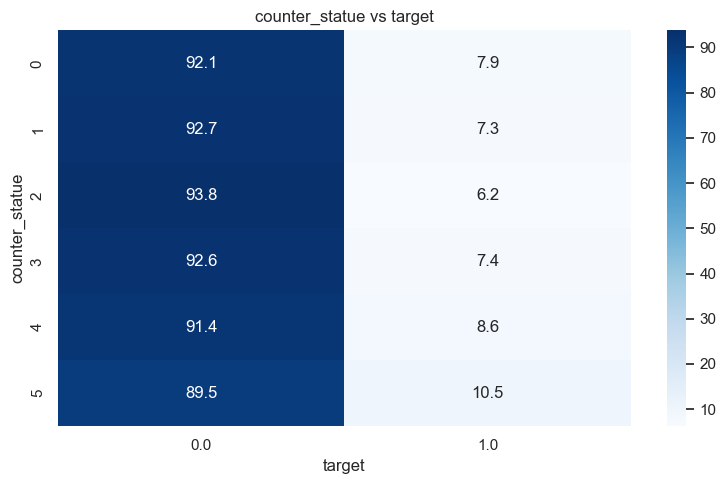

Chi-square statistic: 224.505, p-value: 0.0000
→ Significant association between the two variables (less than 0.05).


In [85]:
plot_categorical_vs_categorical(df,  'counter_statue','target', norm=True)

### counter_code

In [86]:
df['counter_code'].nunique()

40

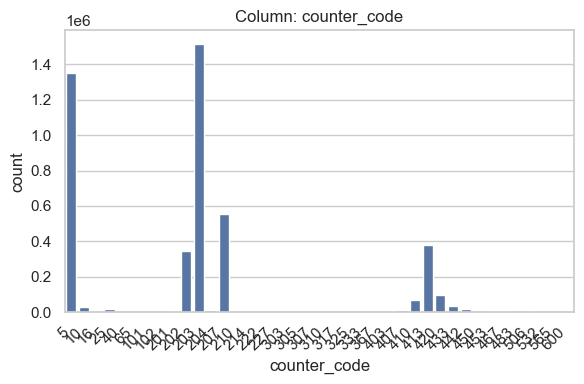

- NaN's Found: 0 (0.0%)
- Unique Values: 40
- Most common value: '203' occurs 1516834 times (33.88%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: counter_code'}, xlabel='counter_code', ylabel='count'>)

In [87]:
explore_categorical(df,'counter_code')

### reading_remarque

In [46]:
invoice_train['reading_remarque'].value_counts()

reading_remarque
6    2230915
9    1416991
8     828123
7        661
Name: count, dtype: int64

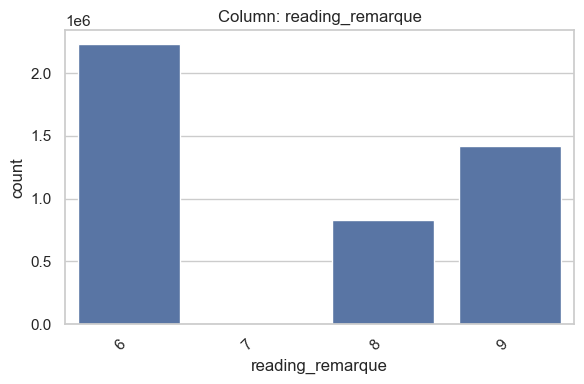

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '6' occurs 2230915 times (49.83%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: reading_remarque'}, xlabel='reading_remarque', ylabel='count'>)

In [47]:
explore_categorical(invoice_train,'reading_remarque')

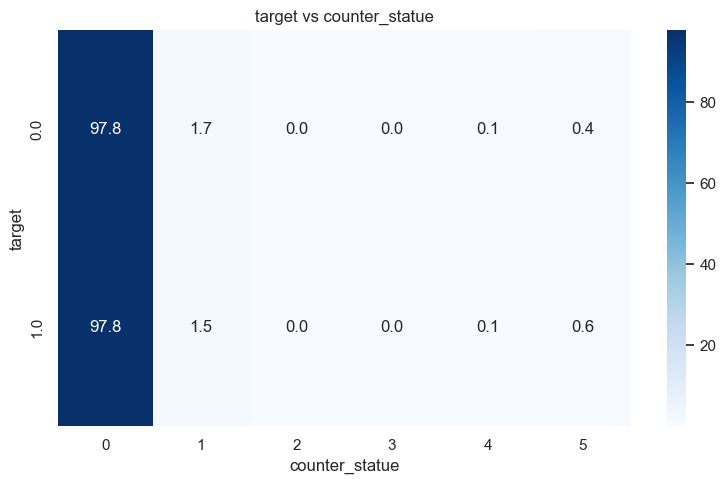

Chi-square statistic: 224.505, p-value: 0.0000
→ Significant association between the two variables (less than 0.05).


In [88]:
plot_categorical_vs_categorical(df, 'target', 'counter_statue', norm=True)

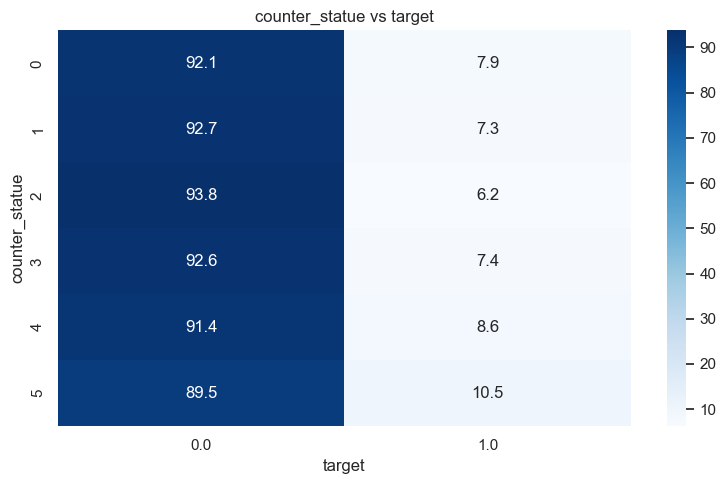

Chi-square statistic: 224.505, p-value: 0.0000
→ Significant association between the two variables (less than 0.05).


In [89]:
plot_categorical_vs_categorical(df,  'counter_statue','target', norm=True)

### counter_coef

In [48]:
invoice_train['counter_coefficient'].value_counts()

counter_coefficient
1     4475077
2         886
3         321
40        197
30        137
0          46
4          12
10          6
20          3
50          2
33          1
5           1
11          1
Name: count, dtype: int64

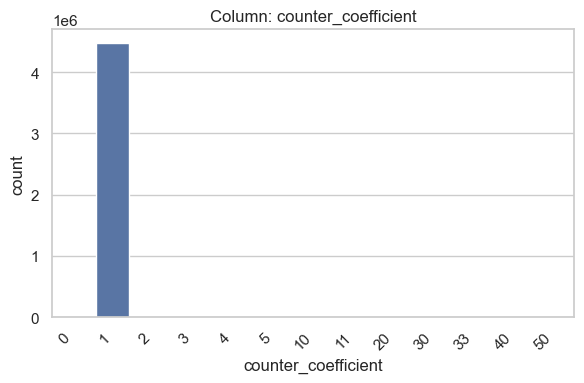

- NaN's Found: 0 (0.0%)
- Unique Values: 13
- Most common value: '1' occurs 4475077 times (99.96%)

- [!] Warning: 'counter_coefficient' is a constant or quasi-constant feature and should be dropped.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: counter_coefficient'}, xlabel='counter_coefficient', ylabel='count'>)

In [49]:
explore_categorical(invoice_train,'counter_coefficient')

This feature should be dropped since there is more than 99% of the rows have counter_coeff==1 (it is qusi-constant feature)

### consuption_level_1

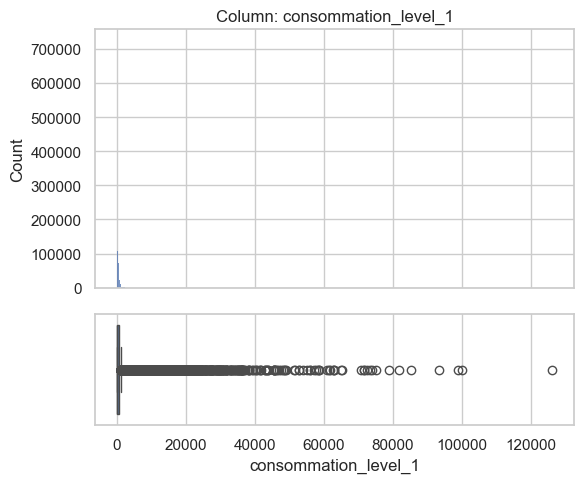

- NaN's Found: 0 (0.0%)


In [50]:
explore_numeric(invoice_train,'consommation_level_1')

* Consumbtion_level_1 has a massive outlaier -> so we must drop it 

In [ ]:
invoice_train.drop(invoice_train[invoice_train['consommation_level_1']==9.999100e+05].index, inplace=True)
invoice_train['consommation_level_1'].describe()

count    4.476690e+06
mean     4.107615e+02
std      5.919165e+02
min      0.000000e+00
25%      7.900000e+01
50%      2.740000e+02
75%      6.000000e+02
max      1.261180e+05
Name: consommation_level_1, dtype: float64

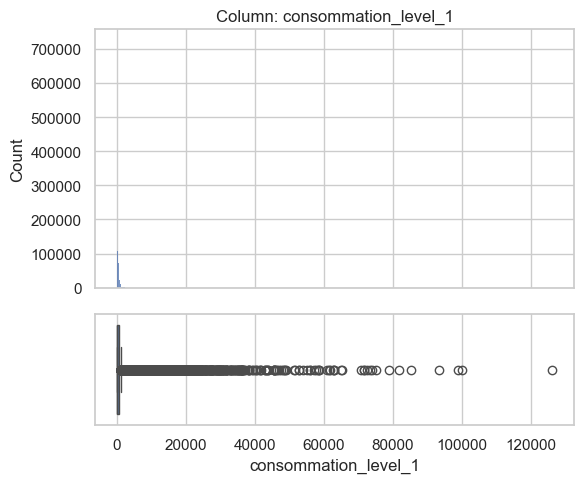

- NaN's Found: 0 (0.0%)


In [ ]:
explore_numeric(invoice_train,'consommation_level_1')

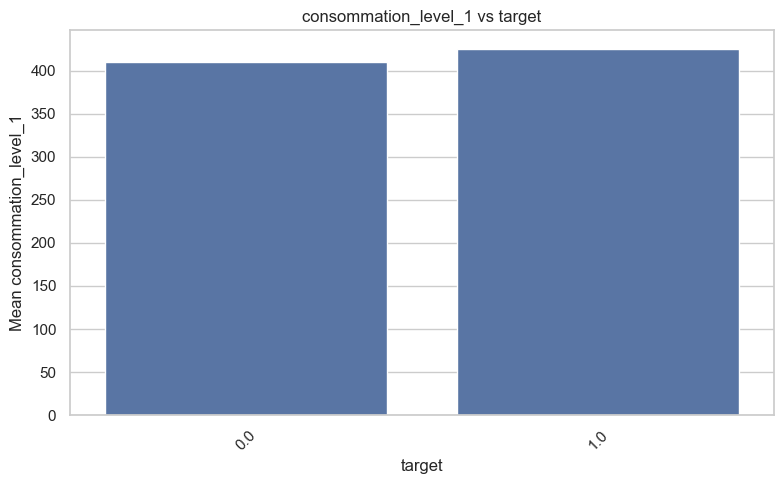

ANOVA F-statistic: 136.061, p-value: 0.0000
→ Significant difference detected between groups.


In [ ]:
plot_numeric_vs_categorical(df, 'target', 'consommation_level_1', norm=False)

### consumptipn_level_2

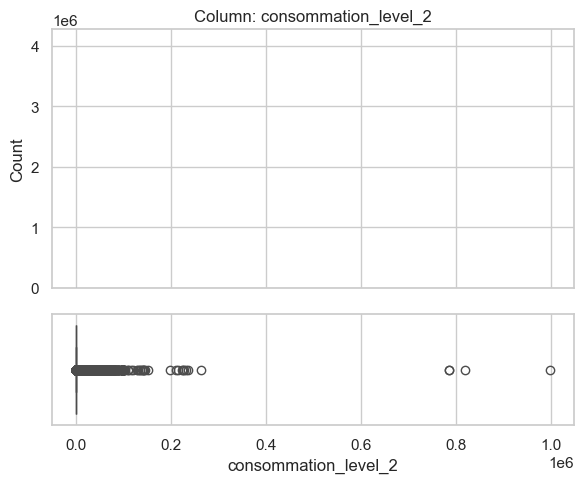

- NaN's Found: 0 (0.0%)


In [51]:
explore_numeric(invoice_train,'consommation_level_2')

In [52]:
invoice_train['consommation_level_2'].describe()

count    4.476690e+06
mean     1.093194e+02
std      1.220129e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.990730e+05
Name: consommation_level_2, dtype: float64

* THere are massive outlaiers ,we should drop them

In [53]:
invoice_train[invoice_train['consommation_level_2']>0.4e5].head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
5257,train_Client_100144,2012-06-04,11,543494,0,207,6,1,600,99398,0,0,19772,19770,2,ELEC
16504,train_Client_100440,2013-04-24,11,109700,0,420,9,1,3600,77377,0,0,15,80992,12,ELEC
113261,train_Client_103062,2008-08-01,11,463774,0,506,9,1,1200,60146,0,0,13994,75340,4,ELEC
113266,train_Client_103062,2008-09-05,11,463774,0,506,9,1,1200,75114,0,0,75340,151654,4,ELEC
118206,train_Client_103191,2008-10-04,11,122789,0,420,9,1,2400,55096,0,0,162348,219844,8,ELEC


### consumption_level_3

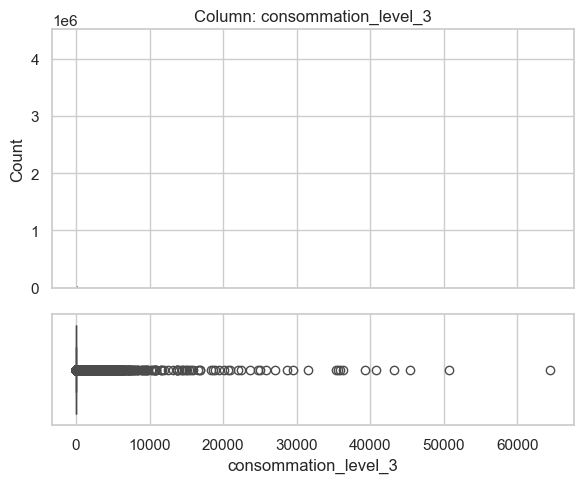

- NaN's Found: 0 (0.0%)


In [54]:
explore_numeric(invoice_train,'consommation_level_3')

### consumption_level_4

<Axes: xlabel='consommation_level_4', ylabel='Count'>

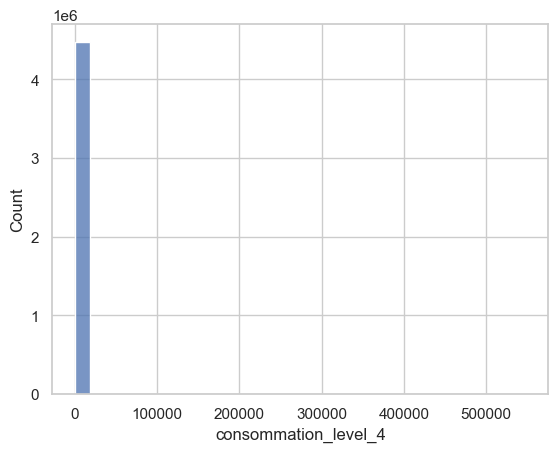

In [55]:
sns.histplot(invoice_train['consommation_level_4'], bins=30, kde=False)

In [56]:
invoice_train['consommation_level_4'].describe()

count    4.476690e+06
mean     5.292658e+01
std      8.754782e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.479460e+05
Name: consommation_level_4, dtype: float64

* tHE FIGURE AND THE DESCRIPTION shows that there is a huge outlaier in the consommation_level_4 

In [57]:
invoice_train[invoice_train['consommation_level_4']==5.479460e+05]['consommation_level_4'].count()

np.int64(1)

In [58]:
invoice_train[invoice_train['consommation_level_4']==5.479460e+05]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
3479829,train_Client_72985,2017-03-05,11,2168701765600,0,420,9,1,400,200,400,547946,0,548946,2,ELEC


In [59]:
invoice_train.drop(invoice_train[invoice_train['consommation_level_4']==5.479460e+05].index,inplace=True)

In [60]:
invoice_train['consommation_level_4'].describe()

count    4.476689e+06
mean     5.280419e+01
std      8.363054e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.435680e+05
Name: consommation_level_4, dtype: float64

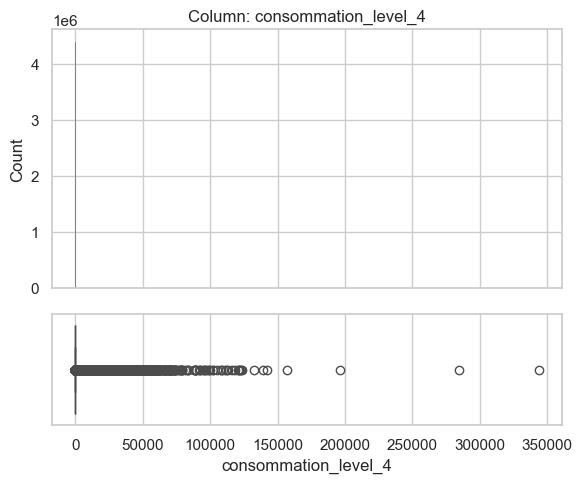

- NaN's Found: 0 (0.0%)


In [61]:
explore_numeric(invoice_train,'consommation_level_4')

* There are still some massive outlayers

In [62]:
invoice_train[invoice_train['consommation_level_4']>150000]['client_id'].count()

np.int64(4)

In [63]:
invoice_train.drop(invoice_train[invoice_train['consommation_level_4']>150000].index, inplace=True)

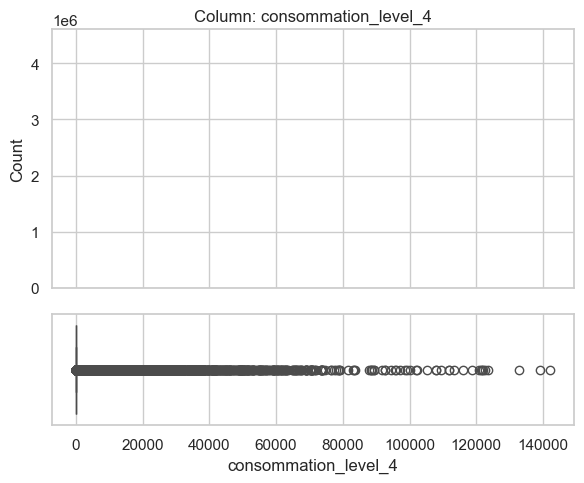

- NaN's Found: 0 (0.0%)


In [64]:
explore_numeric(invoice_train,'consommation_level_4')

### old_index

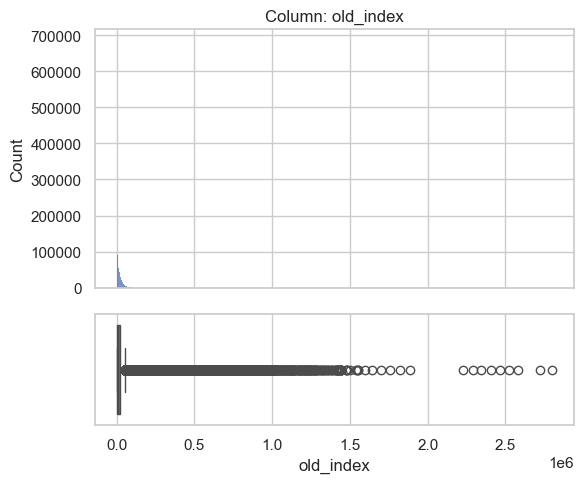

- NaN's Found: 0 (0.0%)


In [65]:
explore_numeric(invoice_train,'old_index')

### new_index

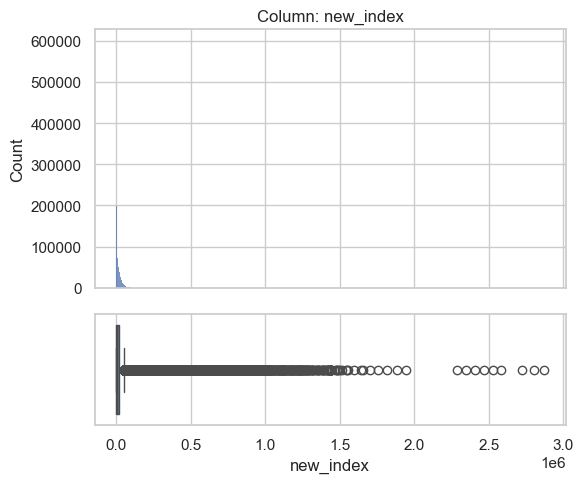

- NaN's Found: 0 (0.0%)


In [66]:
explore_numeric(invoice_train,'new_index')

### months_number

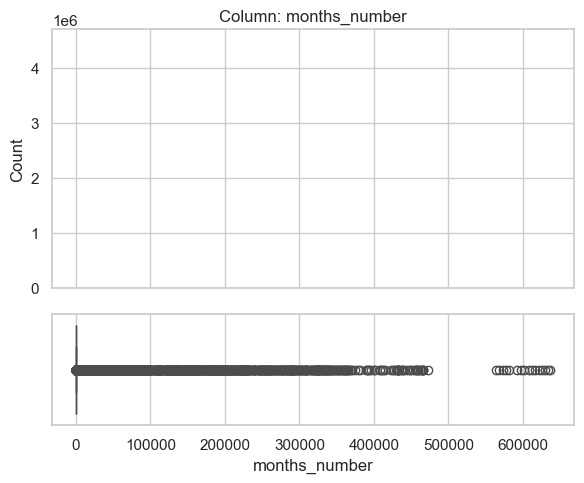

- NaN's Found: 0 (0.0%)


In [67]:
explore_numeric(invoice_train,'months_number')

### counter_type

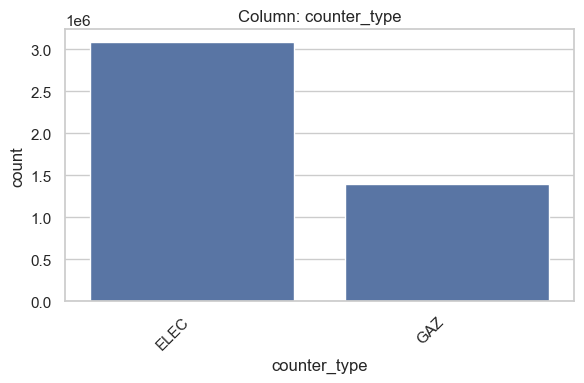

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'ELEC' occurs 3079347 times (68.79%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: counter_type'}, xlabel='counter_type', ylabel='count'>)

In [93]:
explore_categorical(invoice_train,'counter_type')

# Multivariant 

# Preprocessing

In [92]:
invoice_train.columns

Index(['client_id', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type'],
      dtype='object')

In [ ]:
client_train.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target'],
      dtype='object')

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
keep_cols=['fraud','months_number','counter_type','consommation_level_1',
           'consommation_level_2','consommation_level_3',]

In [ ]:
# define the Target and the features
y=invoice_train['fraud']
# X=invoice_train.drop(columns=['fraud_reported','invoice_date','client_id'])

# Modeling